<a href="https://colab.research.google.com/github/Sainaveengunda/Netflix-Recommendations-NLP/blob/main/Netflix_Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-surprise

# Import the necessary libraries
import pandas as pd  # For data manipulation
import numpy as np   # For numerical operations
from surprise import Dataset, Reader  # For collaborative filtering
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy  # For evaluating recommendation system

# For Content-Based Filtering
from sklearn.feature_extraction.text import TfidfVectorizer  # For text feature extraction
from sklearn.metrics.pairwise import linear_kernel  # For computing similarity


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163338 sha256=8027019f76553888b5807547bcda23befdc276541b7e8810673c139f52de6e42
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
# Loading netflix data
movies_df = pd.read_csv('netflix_titles.csv')

# Display the first few rows of the dataset to ensure it's loaded correctly
movies_df.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [ ]:
# Get the column names of categorical variables (object data type)
categorical_column_names = movies_df.select_dtypes(include=['object']).columns.tolist()

# Get the column names of continuous variables (int64 and float64 data types)
continuous_column_names = movies_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
continuous_column_names

['release_year']

In [ ]:
# Displaying all column names of dataframe 'movies_df'
column_names = movies_df.columns
print(column_names)


Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')


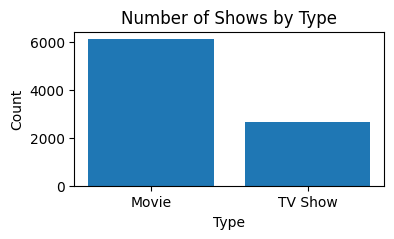

In [ ]:
import matplotlib.pyplot as plt

# Count the number of shows by type
type_counts = movies_df['type'].value_counts()

# Create a bar chart
plt.figure(figsize=(4, 2))
plt.bar(type_counts.index, type_counts.values)
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Number of Shows by Type')
plt.show()


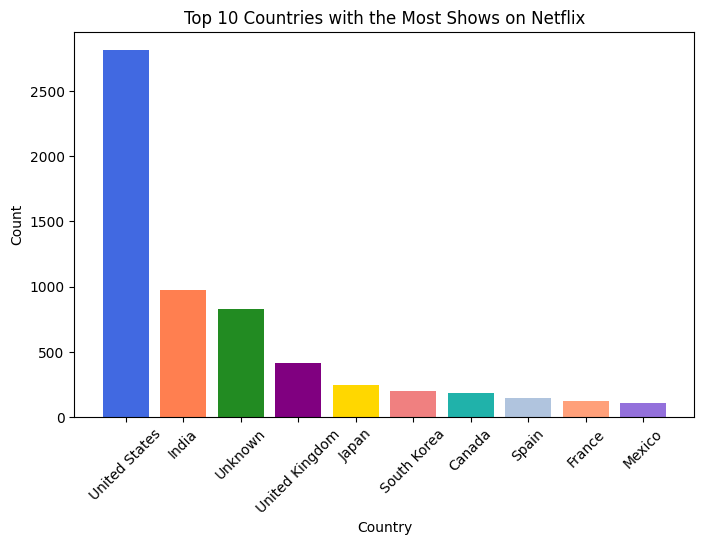

In [ ]:
import matplotlib.pyplot as plt

# Count the number of shows by country
country_counts = movies_df['country'].value_counts()[:10]  # Display the top 10 countries

# Define a color palette
colors = ['royalblue', 'coral', 'forestgreen', 'purple', 'gold', 'lightcoral', 'lightseagreen', 'lightsteelblue', 'lightsalmon', 'mediumpurple']

# Create a bar chart with custom colors
plt.figure(figsize=(8, 5))
plt.bar(country_counts.index, country_counts.values, color=colors)
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Top 10 Countries with the Most Shows on Netflix')
plt.xticks(rotation=45)  # Rotate country names for better readability
plt.show()



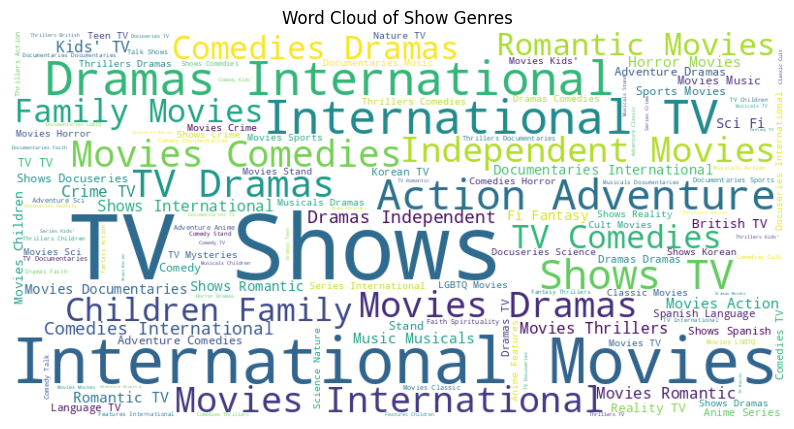

In [ ]:
from wordcloud import WordCloud

# Combine all genres into a single string
all_genres = ' '.join(movies_df['listed_in'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_genres)

# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Show Genres')
plt.show()


# Data Preprocessing

In [ ]:
# Check for null values in the DataFrame
null_values = movies_df.isnull().sum()

# Print the count of null values for each column
print(null_values)


show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


In [ ]:
#Impute Missing Values
movies_df['director'].fillna('Unknown', inplace=True)
movies_df['cast'].fillna('Unknown', inplace=True)
movies_df['country'].fillna('Unknown', inplace=True)
columns_to_check = ['release_year', 'rating', 'duration', 'date_added']
movies_df = movies_df.dropna(subset=columns_to_check)

<ipython-input-23-d496d4a4a44b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['director'].fillna('Unknown', inplace=True)
<ipython-input-23-d496d4a4a44b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['cast'].fillna('Unknown', inplace=True)
<ipython-input-23-d496d4a4a44b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['country'].fillna('Unknown', inplace=True)


In [ ]:
# Check for null values in the DataFrame
null_values = movies_df.isnull().sum()

# Print the count of null values for each column
print(null_values)

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64


In [ ]:
import re

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    return text

movies_df['description'] = movies_df['description'].apply(clean_text)


In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
def tokenize_text(text):
    return word_tokenize(text)

movies_df['description'] = movies_df['description'].apply(tokenize_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word.lower() not in stop_words]

movies_df['description'] = movies_df['description'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_df['description'].apply(lambda x: ' '.join(x)))


In [ ]:
#using Word2Vec (Gensim library)
from gensim.models import Word2Vec

# Train Word2Vec model on tokenized descriptions
w2v_model = Word2Vec(movies_df['description'], vector_size=100, window=5, min_count=1, sg=0)


In [ ]:
#using Doc2Vec (Gensim library)
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(words=desc, tags=[str(i)]) for i, desc in enumerate(movies_df['description'])]
doc2vec_model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarities between movies based on their embeddings
similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [ ]:
# Calculate cosine similarities between movies based on their embeddings
similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Print the similarity scores for the first few movies
for i in range(5):  # Print for the first 5 movies as an example
    print(f"Similarity scores for {movies_df.iloc[i]['title']}:")
    for j in range(5):  # Print similarity scores for the first 5 movies as an example
        print(f"   {movies_df.iloc[j]['title']}: {similarities[i][j]}")
    print()


Similarity scores for Dick Johnson Is Dead:
   Dick Johnson Is Dead: 0.9999999999999999
   Blood & Water: 0.0
   Ganglands: 0.0
   Jailbirds New Orleans: 0.0
   Kota Factory: 0.015218877651706311

Similarity scores for Blood & Water:
   Dick Johnson Is Dead: 0.0
   Blood & Water: 1.0000000000000004
   Ganglands: 0.0
   Jailbirds New Orleans: 0.0
   Kota Factory: 0.0

Similarity scores for Ganglands:
   Dick Johnson Is Dead: 0.0
   Blood & Water: 0.0
   Ganglands: 1.0
   Jailbirds New Orleans: 0.0
   Kota Factory: 0.0

Similarity scores for Jailbirds New Orleans:
   Dick Johnson Is Dead: 0.0
   Blood & Water: 0.0
   Ganglands: 0.0
   Jailbirds New Orleans: 1.0000000000000004
   Kota Factory: 0.0

Similarity scores for Kota Factory:
   Dick Johnson Is Dead: 0.015218877651706311
   Blood & Water: 0.0
   Ganglands: 0.0
   Jailbirds New Orleans: 0.0
   Kota Factory: 0.9999999999999999



In [ ]:
def get_recommendations(movie_title, num_recommendations=7):
    matching_movies = movies_df[movies_df['title'].str.contains(movie_title, case=False)]

    if matching_movies.empty:
        print(f"No matching movies found for '{movie_title}'.")
        return

    movie_index = matching_movies.index[0]
    similar_movies = list(enumerate(similarities[movie_index]))
    similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)
    top_similar_movies = similar_movies[1:num_recommendations + 1]  # Exclude the movie itself
    recommended_movies = [movies_df.iloc[movie[0]]['title'] for movie in top_similar_movies]
    return recommended_movies



In [ ]:
# Example: Recommend top 5 movies based on a given movie using the modified function
movie_title = "Kota Factory"
top_movies = get_recommendations(movie_title, num_recommendations=7)
if top_movies:
    print(f"Recommended movies based on '{movie_title}':")
    for i, movie in enumerate(top_movies):
        print(f"{i + 1}. {movie}")


Recommended movies based on 'Kota Factory':
1. Drishyam
2. The Creative Indians
3. The Bridge Curse
4. She's Dating the Gangster
5. Racket Boys
6. Code 8
7. Girl's Revenge
